## Reproduce DARTFISH results with Starfish

DARTFISH is a multiplexed image based transcriptomics assay from the [Zhang lab](http://genome-tech.ucsd.edu/ZhangLab/). As of this writing, this assay is not published yet. Nevertheless, here we demonstrate that Starfish can be used to process the data from raw images into spatially resolved gene expression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from starfish import display
from starfish import data, FieldOfView
from starfish.types import Features, Axes

from starfish import IntensityTable

from starfish.image import Filter
from starfish.spots import PixelSpotDecoder

sns.set_context('talk')
sns.set_style('ticks')

/usr/local/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


### Load data from the cloud.

The example data here corresopond to DARTFISHv1 2017. The group is actively working on improving the protocol. The data represent human brain tissue from the human occipital cortex from 1 field of view (FOV) of larger experiment

In [3]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
exp = data.DARTFISH(use_test_data=use_test_data)

imgs = exp.fov().get_image(FieldOfView.PRIMARY_IMAGES)

100%|██████████| 18/18 [00:00<00:00, 62.10it/s]


In [30]:
print(stack.shape)

OrderedDict([(<Axes.ROUND: 'r'>, 6), (<Axes.CH: 'c'>, 3), (<Axes.ZPLANE: 'z'>, 1), ('y', 988), ('x', 988)])


In [31]:
%gui qt5
display(stack)

### Load codebook

In [32]:
exp.codebook

<xarray.Codebook (target: 96, c: 3, r: 6)>
array([[[0, 1, ..., 0, 0],
        [0, 0, ..., 1, 0],
        [1, 0, ..., 0, 0]],

       [[0, 1, ..., 1, 0],
        [1, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 1, ..., 1, 0],
        [1, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 1],
        [1, 1, ..., 0, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'MYH11' 'RELN' 'NR4A2' 'COL20A1' 'IGFBP5' ...
  * c        (c) int64 0 1 2
  * r        (r) int64 0 1 2 3 4 5

### Load copy number benchmark results

In [33]:
cnts_benchmark = pd.read_csv('https://d2nhj9g34unfro.cloudfront.net/20181005/DARTFISH/fov_001/counts.csv')
cnts_benchmark.head()

,gene,cnt
0,MYH11,29
1,RELN,22
2,NR4A2,20
3,COL20A1,14
4,IGFBP5,13


### Filter Image Stack

In [34]:
sc_filt = Filter.ScaleByPercentile(p=100)
z_filt = Filter.ZeroByChannelMagnitude(thresh=.05, normalize=False)

norm_stack = sc_filt.run(stack)
zero_norm_stack = z_filt.run(norm_stack)

#### Visualize barcode magnitudes to help determine an appropriate threshold for decoding

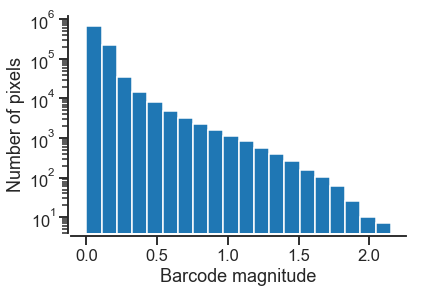

In [35]:
def compute_magnitudes(stack, norm_order=2):

    pixel_intensities = IntensityTable.from_image_stack(zero_norm_stack)
    feature_traces = pixel_intensities.stack(traces=(Axes.CH.value, Axes.ROUND.value))
    norm = np.linalg.norm(feature_traces.values, ord=norm_order, axis=1)

    return norm

mags = compute_magnitudes(zero_norm_stack)

plt.hist(mags, bins=20);
sns.despine(offset=3)
plt.xlabel('Barcode magnitude')
plt.ylabel('Number of pixels')
plt.yscale('log');

### Decode

In [36]:
# how much magnitude should a barcode have for it to be considered by decoding? this was set by looking at
# the plot above
magnitude_threshold = 0.5
# how big do we expect our spots to me, min/max size. this was set to be equivalent to the parameters
# determined by the Zhang lab.
area_threshold = (5, 30)
# how close, in euclidean space, should the pixel barcode be to the nearest barcode it was called to?
# here, I set this to be a large number, so I can inspect the distribution of decoded distances below
distance_threshold = 3

psd = PixelSpotDecoder.PixelSpotDecoder(
    codebook=exp.codebook,
    metric='euclidean',
    distance_threshold=distance_threshold,
    magnitude_threshold=magnitude_threshold,
    min_area=area_threshold[0],
    max_area=area_threshold[1]
)

initial_spot_intensities, results = psd.run(zero_norm_stack)

100%|██████████| 5289/5289 [00:01<00:00, 3856.61it/s]


In [37]:
spots_df = initial_spot_intensities.to_features_dataframe()
spots_df['area'] = np.pi*spots_df['radius']**2
spots_df = spots_df.loc[spots_df[Features.PASSES_THRESHOLDS]]
spots_df.head()

,radius,target,x,y,z,distance,passes_thresholds,features,xc,yc,zc,area
2,1.954410,EXPH5,954,0,0,0.645943,True,2,0.000967,0.000000,0.0005,12.0
5,1.954410,RNF152,928,3,0,0.458121,True,5,0.000940,0.000003,0.0005,12.0
7,1.954410,PLD4,295,5,0,0.540604,True,7,0.000299,0.000005,0.0005,12.0
11,2.034214,CTSS,225,7,0,0.727112,True,11,0.000228,0.000007,0.0005,13.0
12,2.185097,PCP4,383,7,0,0.523660,True,12,0.000388,0.000007,0.0005,15.0


### QC Plots

#### parameter tuning plots

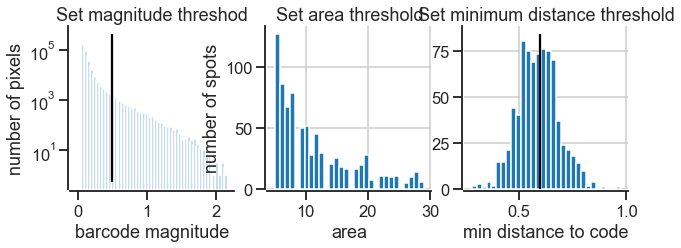

In [38]:
# these plots help inform how the parameters above were set.
# looking at the last plot below, I reset the distance_threshold parameter to
min_dist = 0.6

plt.figure(figsize=(10,3))

plt.subplot(131)
plt.hist(mags, bins=100);
plt.yscale('log')
plt.xlabel('barcode magnitude')
plt.ylabel('number of pixels')
sns.despine(offset=2)
plt.vlines(magnitude_threshold, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1])
plt.title('Set magnitude threshod')

plt.subplot(132)
spots_df['area'] = np.pi*spots_df.radius**2
spots_df.area.hist(bins=30);
plt.xlabel('area')
plt.ylabel('number of spots')
sns.despine(offset=2)
plt.title('Set area threshold')

plt.subplot(133)
spots_df.distance.hist(bins=30)
plt.xlabel('min distance to code');
plt.vlines(min_dist, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1])
sns.despine(offset=2)
plt.title('Set minimum distance threshold');

#### Copy number comparisons

In [39]:
# select spots with distance less than a threshold, and count the number of each target gene
cnts_starfish = spots_df[spots_df.distance<=min_dist].groupby('target').count()['area']
cnts_starfish = cnts_starfish.reset_index(level=0)
cnts_starfish.rename(columns = {'target':'gene', 'area':'cnt_starfish'}, inplace=True)

benchmark_comparison = pd.merge(cnts_benchmark, cnts_starfish, on='gene', how='left')
benchmark_comparison.head(20)

,gene,cnt,cnt_starfish
0,MYH11,29,32.0
1,RELN,22,10.0
2,NR4A2,20,30.0
3,COL20A1,14,15.0
4,IGFBP5,13,8.0
5,JAG1,12,27.0
6,ADCY8,12,12.0
7,ANKRD13A,10,22.0
8,INPP5D,9,6.0
9,MBP,8,20.0


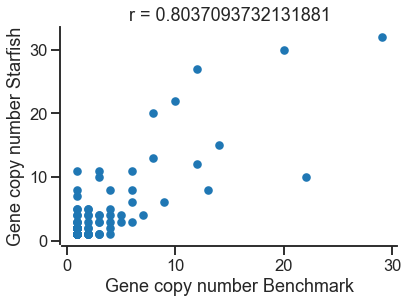

In [40]:
x = benchmark_comparison.dropna().cnt.values
y = benchmark_comparison.dropna().cnt_starfish.values
r = np.corrcoef(x, y)
r = r[0,1]

plt.scatter(x, y, 50,zorder=2)

plt.xlabel('Gene copy number Benchmark')
plt.ylabel('Gene copy number Starfish')
plt.title('r = {}'.format(r))

sns.despine(offset=2)

#### visualization of rolonies

In [41]:
distance_threshold = min_dist

psd = PixelSpotDecoder.PixelSpotDecoder(
    codebook=exp.codebook,
    metric='euclidean',
    distance_threshold=distance_threshold,
    magnitude_threshold=magnitude_threshold,
    min_area=area_threshold[0],
    max_area=area_threshold[1]
)

spot_intensities, results = psd.run(zero_norm_stack)
spot_intensities = IntensityTable(spot_intensities.where(spot_intensities[Features.PASSES_THRESHOLDS], drop=True))

100%|██████████| 2167/2167 [00:01<00:00, 1659.22it/s]


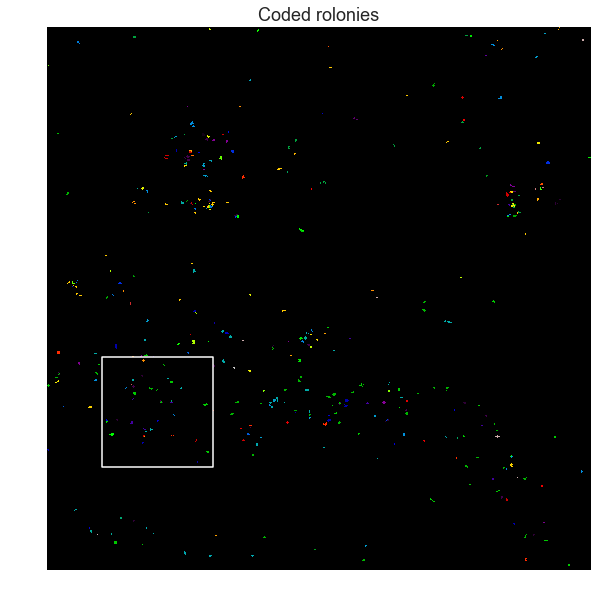

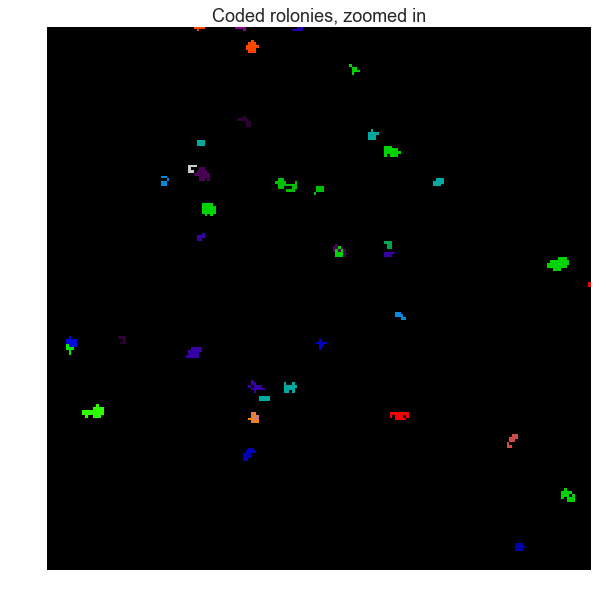

In [42]:
# exclude spots that don't meet our area thresholds
area_lookup = lambda x: 0 if x == 0 else results.region_properties[x - 1].area
vfunc = np.vectorize(area_lookup)
mask = np.squeeze(vfunc(results.label_image))
new_image = np.squeeze(results.decoded_image)*(mask > area_threshold[0])*(mask < area_threshold[1])

plt.figure(figsize=(10,10))
plt.imshow(new_image, cmap = 'nipy_spectral');
plt.axis('off');
plt.title('Coded rolonies');

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

rect = [Rectangle((100, 600), width=200, height=200)]
pc = PatchCollection(rect, facecolor='none', alpha=1.0, edgecolor='w', linewidth=1.5)
plt.gca().add_collection(pc)

plt.figure(figsize=(10,10))
plt.imshow(new_image[600:800, 100:300], cmap = 'nipy_spectral');
plt.axis('off');
plt.title('Coded rolonies, zoomed in');

### visualization of matched barcodes
here, we 1. pick a rolony that was succesfully decoded to a gene. 2. pull out the average pixel trace for that rolony and 3. plot that pixel trace against the barcode of that gene

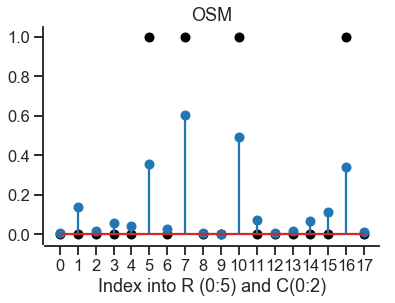

In [43]:
# reshape the spot intensity table into a RxC barcode vector
pixel_traces = spot_intensities.stack(traces=(Axes.ROUND.value, Axes.CH.value))

# extract dataframe from spot intensity table for indexing purposes
pixel_traces_df = pixel_traces.to_features_dataframe()
pixel_traces_df['area'] = np.pi*pixel_traces_df.radius**2

# pick index of a barcode that was read and decoded from the ImageStack
ind = 4

# The test will error here on pixel_traces[ind,:] with an out of index error
# because we are using the test data.

# get the the corresponding gene this barcode was decoded to
gene = pixel_traces_df.loc[ind].target

# query the codebook for the actual barcode corresponding to this gene
real_barcode = exp.codebook[exp.codebook.target==gene].stack(traces=(Axes.ROUND.value, Axes.CH.value)).values[0]
read_out_barcode = pixel_traces[ind,:]

plt.plot(real_barcode, 'ok')
plt.stem(read_out_barcode)
sns.despine(offset=2)
plt.xticks(range(18))
plt.title(gene)
plt.xlabel('Index into R (0:5) and C(0:2)');